# Cold War Simulation Analysis
## Experiment 1 -- Original model replication, book data

In [1]:
import copy
import pickle
import random
from collections import defaultdict, namedtuple, Counter
from itertools import combinations, permutations
import os

import numpy as np
import scipy.stats

import pandas as pd
import networkx as nx
import statsmodels.api as sm

import matplotlib.pyplot as plt
%matplotlib inline

# Loading original data

In [2]:
book_data = pd.read_csv("BDM_ColdWar.csv")
book_data.Position = (book_data.Position + 100)/200

In [3]:
book_data.head()

,Country,Capability,Position
0,Argentina,0.972,0.9480
1,Australia,0.889,0.5065
2,Belgium,1.182,0.5140
3,Brazil,0.993,0.9480
4,Bulgaria,0.345,0.0000


# Data serialization

In [4]:
class Model_Output:
    def __init__(self, model):
        '''
        Store data from model run.
        '''
        self.agent_vars = model.datacollector.get_agent_vars_dataframe()
        self.model_vars = model.datacollector.get_model_vars_dataframe()
        self.log = model.log

In [5]:
model_runs = []
for i in [1, 2, 3, 4]:
    filename = "data_output/ColdWar_Experiment1_{}.pickle".format(i)
    with open(filename, "rb") as f:
        model_runs += pickle.load(f)

In [6]:
len(model_runs)

1300

# Analyzing median positions

In [7]:
all_dfs = []
for i, model in enumerate(model_runs):
    df = model.model_vars.copy()
    df.reset_index(inplace=True)
    df.rename(columns={"index": "Step"}, inplace=True)
    df["Iteration"] = i
    all_dfs.append(df)
results = pd.concat(all_dfs)

In [8]:
results.tail()

,Step,Mean,Median,Iteration
20,20,0.697487,0.947243,1299
21,21,0.533788,0.507350,1299
22,22,0.662403,0.515230,1299
23,23,0.560680,0.513346,1299
24,24,0.562957,0.510066,1299


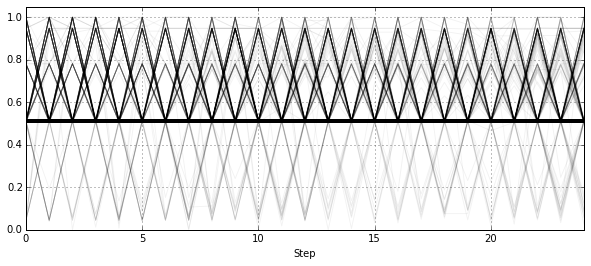

In [9]:
# Plot all runs
fig, ax = plt.subplots(figsize=(10, 4))
for i, group in results.groupby("Iteration"):
    group.plot(x="Step", y="Median", color='k', alpha=0.05, ax=ax, legend=False)

ax.set_ylim(0, 1.05)
ax.grid(True)

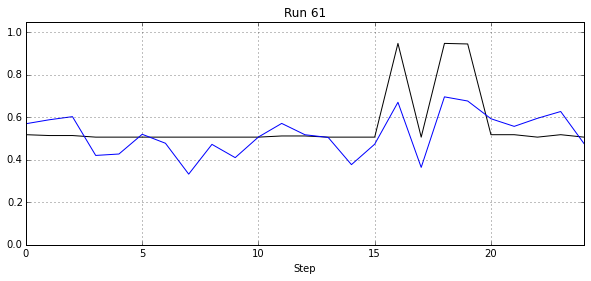

In [10]:
# Pick one trace at random
fig, ax = plt.subplots(figsize=(10, 4))
i = random.randint(0, 1299)
subset = results[results.Iteration==i]
subset.plot(x="Step", y="Median", color='k', ax=ax, legend=False)
subset.plot(x="Step", y="Mean", color='b', ax=ax, legend=False)

ax.set_ylim(0, 1.05)
ax.set_title("Run " + str(i))
ax.grid(True)

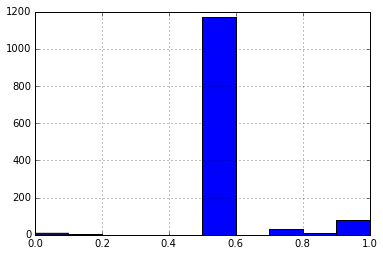

In [11]:
results[results.Step==24]["Median"].hist(bins=np.linspace(0, 1, 11))

**Look at only runs where one side "wins".**

In [12]:
# Get iterations where US wins
us_win = results[(results.Step==24) & (results.Median>0.8)]["Iteration"].unique()

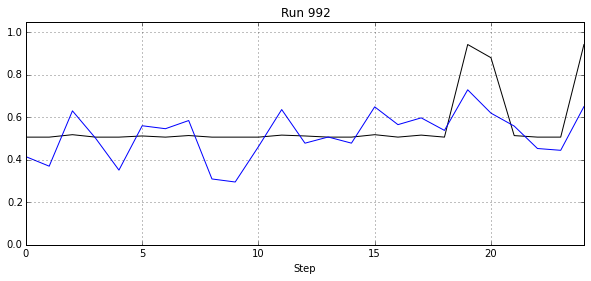

In [13]:
# Plot US victories
fig, ax = plt.subplots(figsize=(10, 4))
i = random.choice(us_win)
subset = results[results.Iteration==i]
subset.plot(x="Step", y="Median", color='k', ax=ax, legend=False)
subset.plot(x="Step", y="Mean", color='b', ax=ax, legend=False)

ax.set_ylim(0, 1.05)
ax.set_title("Run " + str(i))
ax.grid(True)

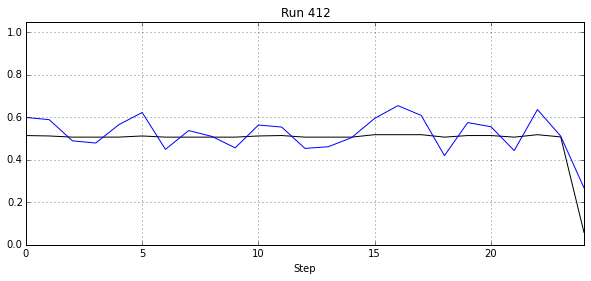

In [14]:
# Get iterations where USSR wins
ussr_win = results[(results.Step==24) & (results.Median<0.2)]["Iteration"].unique()
fig, ax = plt.subplots(figsize=(10, 4))
i = random.choice(ussr_win)
subset = results[results.Iteration==i]
subset.plot(x="Step", y="Median", color='k', ax=ax, legend=False)
subset.plot(x="Step", y="Mean", color='b', ax=ax, legend=False)

ax.set_ylim(0, 1.05)
ax.set_title("Run " + str(i))
ax.grid(True)

In [15]:
len(ussr_win)

14

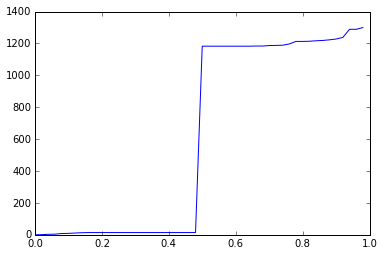

In [16]:
values, base = np.histogram(results[results.Step==24]["Median"], bins=np.linspace(0,1,51))
cdf = np.cumsum(values)
plt.plot(base[:-1], cdf)

In [17]:
import pyobjclipboard

In [21]:
pyobjclipboard.copy_object((base, cdf))

In [ ]:
values, base = np.histogram(results[results.Step==24]["Median"], bins=np.linspace(0,1,51))
cdf = np.cumsum(values)
cdf = cdf/ cdf.max()
fig, ax = plt.subplots(figsize=(8, 5))
ax.plot(base[:-1], cdf, color='k', lw=2)
ax.grid(True)
ax.set_xlabel("Final median position", fontdict)
for spine in ["top", "left", "right", "bottom"]:
    ax.spines[spine].set_visible(False)

## Deep dive into one run

In [ ]:
#run_choice = 796
run_choice = 512
fig, ax = plt.subplots(figsize=(10, 4))
subset = results[results.Iteration==run_choice]
subset.plot(x="Step", y="Median", color='k', ax=ax, legend=False)
subset.plot(x="Step", y="Mean", color='b', ax=ax, legend=False)

ax.set_ylim(0, 1.05)
ax.set_title("Run " + str(i))
ax.grid(True)

In [ ]:
subset

In [ ]:
m = model_runs[run_choice]

In [ ]:
agent_positions = m.agent_vars.copy()
agent_positions.reset_index(inplace=True)

In [ ]:
fig, ax = plt.subplots(figsize=(10, 4))

for i, group in agent_positions.groupby("AgentID"):
    group.plot(x="Step", y="Position", ax=ax, legend=False)

ax.set_ylim(0, 1.05)

In [ ]:
fig = plt.figure(figsize=(15, 15))
fig_num = 1

for name, group in agent_positions.groupby("AgentID"):
    ax = fig.add_subplot(6,6,fig_num)
    group.plot(x="Step", y="Position", ax=ax, legend=False)
    ax.set_title(name)
    ax.set_ylim(0, 1.05)
    fig_num += 1

fig.tight_layout()

In [ ]:
fig = plt.figure(figsize=(15, 15))
fig_num = 1

for name, group in agent_positions.groupby("AgentID"):
    ax = fig.add_subplot(6,6,fig_num)
    group.plot(x="Step", y="Position", ax=ax, legend=False)
    y0, y1 = ax.get_ylim()
    ax.vlines(4, y0, y1, linestyles='--')
    ax.vlines(18, y0, y1, linestyles='--')
    ax.set_title(name)
    # ax.set_ylim(0, 1.05)
    fig_num += 1
    

fig.tight_layout()

In [ ]:
fig.savefig("Output.png", dpi=300)

In [ ]:
m.log.get_events(action="Attack")

In [ ]:
# Average unweighted postion

In [ ]:
average_position = agent_positions.groupby("Step").aggregate("mean")

In [ ]:
average_position.plot()

# Agent position analysis

In [ ]:
all_dfs = []
for i, model in enumerate(model_runs):
    df = model.agent_vars.copy()
    df.reset_index(inplace=True)
    df["Iteration"] = i
    all_dfs.append(df)
agent_positions = pd.concat(all_dfs)

In [ ]:
agent_positions.tail()

## How far do agents end up from their starting position?

In [ ]:
end_positions = agent_positions[agent_positions.Step==24]\
    .groupby("AgentID")["Position"].aggregate([np.mean, np.std])

end_positions = end_positions.rename(columns={"mean": "EndPos_mean",
                             "std": "EndPos_std"})

In [ ]:
end_positions = end_positions.merge(book_data, left_index=True, right_on="Country")

In [ ]:
end_positions.EndPos_std.mean()

In [ ]:
end_positions["Delta"] = end_positions.EndPos_mean - end_positions.Position

In [ ]:
print(end_positions.Delta.mean())
print(end_positions.Delta.min())
print(end_positions.Delta.max())
end_positions.Delta.hist()

In [ ]:
plt.scatter(end_positions.Position, end_positions.EndPos_std)

In [ ]:
plt.scatter(end_positions.Position, end_positions.Delta)

In [ ]:
end_positions.corr()

In [ ]:
end_positions.corr(method='spearman')

In [ ]:
agent_positions[(agent_positions.AgentID=="USA") & 
                (agent_positions.Step==24)]["Position"].hist(bins=np.linspace(0.5, 1, 11))

In [ ]:
agent_positions[(agent_positions.AgentID=="USSR") & 
                (agent_positions.Step==24)]["Position"].hist(bins=np.linspace(0, 0.3, 7))

# Conflict frequencies

In [ ]:
actors = book_data.Country.unique()

In [ ]:
conflict_dyads = Counter()
conflict_models = defaultdict(set)

for i, model in enumerate(model_runs):
    if model.model_vars.Median[24] < 0.75:
        continue
    for event in model.log.get_events(action="Attack"):
        if event.timestamp > 25: # Max steps to consider
            continue
        source = event.source
        target = event.target
        dyad = (source, target)
        if (target, source) in conflict_dyads:
            dyad = (target, source)
        conflict_dyads[dyad] += 0.5
        conflict_models[dyad].add(i)

conflict_models = {k: len(v) for k, v in conflict_models.items()}        
        
# Fill in zeroes
for source, target in permutations(actors, 2):
    dyad = (source, target)
    if (target, source) in conflict_dyads:
        dyad = (target, source)
    if dyad not in conflict_dyads:
        conflict_dyads[dyad] = 0
    if dyad not in conflict_models:
        conflict_models[dyad] = 0

In [ ]:
conflict_dyads.most_common(20)

## Load MID data

In [ ]:
COW = "/Users/dmasad/Data/COW/"
mid_a = pd.read_csv(COW + "MIDA_4.01.csv")
mid_b = pd.read_csv(COW + "MIDB_4.01.csv")

In [ ]:
start_year = 1948
end_year = 1998
#end_year = 1948 + 5

mid_a = mid_a[(mid_a.StYear >= start_year) & (mid_a.StYear <= end_year)]
mid_b = mid_b[(mid_b.StYear >= start_year) & (mid_b.StYear <= end_year)]

### Get state names

In [ ]:
state_names = pd.read_csv(COW + "SystemMembership2011/states2011.csv")
#state_names = state_names[["stateabb", "statenme"]]
state_names = state_names[["ccode", "statenme"]]
state_names.drop_duplicates(inplace=True)

In [ ]:
name_dict = state_names.set_index("statenme").to_dict()["ccode"]

In [ ]:
for name in book_data.Country.unique():
    if name not in name_dict:
        print(name)

In [ ]:
state_names.replace("United Kingdom", "England", inplace=True)
state_names.replace("United States of America", "USA", inplace=True)
state_names.replace("Russia", "USSR", inplace=True)

In [ ]:
#mid_b2 = mid_b.merge(state_names, how="left", left_on="ccode", right_on="stateabb")
mid_b = mid_b.merge(state_names, how="left", on="ccode")

In [ ]:
observed_mids = defaultdict(int)
for dispnum, group in mid_b.groupby("DispNum3"):
    sides = {}
    for side, rows in group.groupby("SideA"):
        sides[side] = rows.statenme.unique()
    # Build dyads
    for side_a in sides[0]:
        for side_b in sides[1]:
            observed_mids[(side_a, side_b)] += 1
            observed_mids[(side_b, side_a)] += 1
observed_mids = dict(observed_mids)

In [ ]:
observed_mids = pd.DataFrame({"Observed_MIDs": observed_mids})
observed_mids.reset_index(inplace=True)
observed_mids.rename(columns={"level_0": "Source_Country",
                               "level_1": "Target_Country"}, inplace=True)

### Merge

In [ ]:
predicted_conflicts = pd.DataFrame({"Predicted_Conflicts": dict(conflict_dyads)})
predicted_conflicts.reset_index(inplace=True)
predicted_conflicts.rename(columns={"level_0": "Source_Country",
                               "level_1": "Target_Country"}, inplace=True)

In [ ]:
conflicts = predicted_conflicts.merge(observed_mids, 'left', 
                                      on=["Source_Country", "Target_Country"])
conflicts.fillna(0, inplace=True)

In [ ]:
plt.scatter(conflicts.Predicted_Conflicts, conflicts.Observed_MIDs)

In [ ]:
conflicts.corr()

In [ ]:
conflicts["Const."] = 1

In [ ]:
lm = sm.OLS(conflicts.Observed_MIDs, conflicts[["Const.", "Predicted_Conflicts"]])
fit = lm.fit()
print(fit.summary())

In [ ]:
with open("lm_ex_1.pickle", "wb") as f:
    pickle.dump(fit, f)

In [ ]:
conflicts["MID_Dummy"] = 0
conflicts["MID_Dummy"][conflicts.Observed_MIDs > 0] = 1

In [ ]:
logit = sm.Logit(conflicts.MID_Dummy, conflicts[["Const.", "Predicted_Conflicts"]])
fit = logit.fit()
print(fit.summary())

In [ ]:
with open("logit_ex_1.pickle", "wb") as f:
    pickle.dump(fit, f)

In [ ]:
conflicts["PredictedConflicts_Dummy"] = 0
conflicts["PredictedConflicts_Dummy"][conflicts.Predicted_Conflicts>0] = 1

In [ ]:
logit = sm.Logit(conflicts.MID_Dummy, conflicts[["Const.", "PredictedConflicts_Dummy"]])
fit = logit.fit()
print(fit.summary())